# Keras image classification development

#### This is a binary image classification test on corn with leaf blight and healthy corn; 
#### We are training using sample images from Kaggle and drone images from Cornell University 
#### ---------------------------------------------------------------------------------------------------------------------------

# To Do for model development:

## Broad/long-term goals

- [ ] Add/reshape model layers
- [ ] Figure out classifications beyond binary
- [ ] Add and tweak decay, momentum, etc. hyperparameters
- [ ] Further research and evaluate optimizer types
- [ ] Try to build our model atop a pre-made model

## Immediate/short-term goals

- [ ] Successfully read and train over all three Cornell datasets
- [ ] Finish cleaning this code for ease of running, accessibility, and configuring training settings
- [ ] Manipulate saved model weights rather than retraining each time

In [1]:
#  basic modules 
import random, datetime
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

#  image and display utilities
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#  our custom modules
import imagereader as ir

#  file utilities
import os, shutil
import h5py
import gc # Garbage collector for cleaning deleted data from memory

In [2]:
#  create sample image sets from the specified folders
list_all = lambda dir: [dir+'{}'.format(i) for i in os.listdir(dir)]

train_healthy = list_all('./input/dataset/train_corn/healthy/')
train_spot = list_all('./input/dataset/train_corn/spot/')
train_rust = list_all('./input/dataset/train_corn/rust/')
train_blight = list_all('./input/dataset/train_corn/blight/')

test_healthy = list_all('./input/dataset/test_corn/healthy/')
test_spot = list_all('./input/dataset/test_corn/spot/')
test_rust = list_all('./input/dataset/test_corn/rust/')
test_blight = list_all('./input/dataset/test_corn/blight/')

#  Create blights/healthy sets for ours model training
train_imgs = train_blight + train_healthy
random.shuffle(train_imgs)

test_imgs = test_blight + test_healthy 
random.shuffle(test_imgs)

In [3]:
def read_and_process_image(list_of_images, image_location, nrows=256, ncolumns=256):
    x = []
    y = []
    
    for image in list_of_images:
        x.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation=cv2.INTER_CUBIC))
        
        if image in image_location:
            y.append(1)
        else:
            y.append(0)
            
    return x, y

#  Processing the training sample images
x, y = read_and_process_image(train_imgs, train_healthy)
#print("Shape of train images is: {}\nShape of Labels is {}".format(x.shape, y.shape))

#  Processing the test sample images
x_test, y_test = read_and_process_image(test_imgs, test_healthy)
#print("Shape of train images is: {}\nShape of Labels is {}".format(x_test.shape, y_test.shape))

gc.collect()

37

Image at 0 is a 0
Image at 1 is a 1
Image at 2 is a 0
Image at 3 is a 1
Image at 4 is a 1


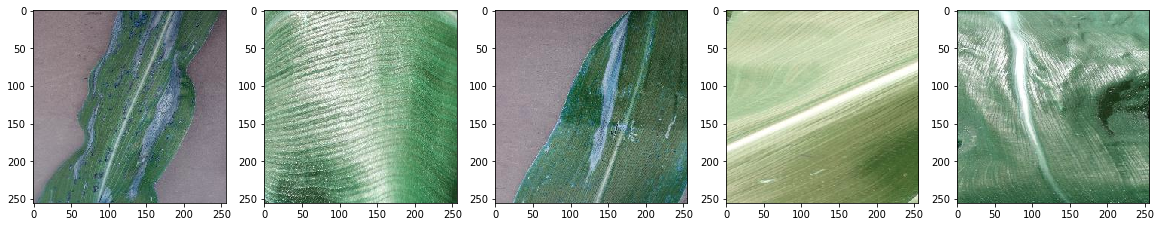

In [4]:
plt.figure(figsize=(20, 10))
columns = 5
for i in range(columns):
    print("Image at",i,"is a", y[i])
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(x[i]) 

Text(0.5, 1.0, 'Labels for Healthy and Blight')

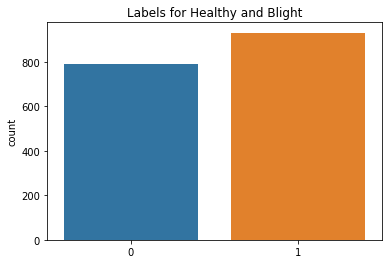

In [5]:
import seaborn as sns

sns.countplot(y)
plt.title('Labels for Healthy and Blight')

In [6]:
#  Suppressing Deprecation warnings
tf.logging.set_verbosity(tf.logging.ERROR)
    
#  setting up keras utilities and model layers
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess= tf.Session(config=config)

# TODO: add/reshape model layers
with tf.device("/gpu:0"):
    model = models.Sequential()  #  model first created
    model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(256, 256, 3))) #  image size taken by model
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))  #Dropout for regularization
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes
    
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 128)       147584    
__________

In [31]:
#  !!CRITICAL FOR FUNCTIONALITY!! - Establish settings for training data creation and formatting

augment_traindata = True  #  determine level of augmentation of data; accuracy/speed tradeoff for True/False respectively
read_method = "from_file" #  'Direct' read is highly not recommended due to time and memory overhead, write to file with ir and read 'from_file' instead

training_set_content = "ours"  #  specify which set is trained over (ours, sample, or mixed)
our_set_content = "drone"  #  specify which one of our image sets is to be read (handheld, drone, or boom)

In [32]:
#  Create the image transformation generators used in the model training
if augment_traindata == False:
    train_datagen = ImageDataGenerator(rescale=1./255)  
elif augment_traindata == True:
    train_datagen = ImageDataGenerator(rescale=1./255,   #  Scale the brightness
                                        rotation_range=40,
                                        #width_shift_range=0.2,
                                        #height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode="reflect")
else:
    print("No augmentation setting specified")

val_datagen = ImageDataGenerator(rescale=1./255)  #  Only ever rescale the validation data for true measure of model accuracy

In [33]:
#  reads images either directly or from the respective hdf5 (as specified above) and creates the appropriate 'pictures' and 'blightvals '
def check_and_read(set_name):
    if read_method == "from_file":
        f = h5py.File('./' + set_name + '_imgs.hdf5', 'r+')  # !METHOD 1! - reading our corn image data from the static file
        pictures = list(f.get('pics')[()])                     #  READTIME is trivial if there is free memory
        f.close()                              
    elif read_method == "direct":  #  !METHOD 2! - reading our corn image data directly from the image folders, several minute readtime
        pictures = ir.read_all_images('images_' + set_name, 'fixed_' + set_name, x=256, y=256)  
    else:
        print("No images read")
    blightvals = ir.get_all_Bools('fixed_' + set_name)  #  <-- NOTE: This always reads the bools directly; 
    return pictures, blightvals

#  control for reading our chosen set    
sets_present = ['handheld', 'drone', 'boom']
if our_set_content in sets_present:
    pictures, blightvals = check_and_read(our_set_content)   
else:
    print("No set specified")

In [34]:
#  formatting our image data
x_train, x_val, y_train, y_val = train_test_split(pictures, blightvals, test_size=0.2) 

#  formatting the sample data
x_sample, x_val1, y_sample, y_val1 = train_test_split(x, y, test_size=0.2)    

#  merges two datasets and mixes them up
def merge_and_shuffle(set1, set2):  #  combines and shuffles a list and nparray (respectively) and  returns a combined array
    modelset = set1 + set2
    random.shuffle(modelset)
    return modelset

#  control for which images/data are trained over
if training_set_content == "ours":  #  training and evaluating over our data
    x_training = x_train
    x_valid = x_val
    y_training = y_train
    y_valid = y_val
    feat, lab = pictures, blightvals
elif training_set_content == "sample":  #  training and evaluating over the sample data
    x_training = x_sample
    x_valid = x_val1
    y_training = y_sample
    y_valid = y_val1
    feat, lab = x_test, y_test
elif training_set_content == "mixed":
    x_training = merge_and_shuffle(x_train, x_sample)  #  mixing the two data sets 
    x_valid = merge_and_shuffle(x_val, x_val1)  #  (has less favorable performance due to disparity in images)
    y_training = merge_and_shuffle(y_train, y_sample)
    y_valid = merge_and_shuffle(y_val, y_val1)
    feat, lab = pictures + x_test, blightvals + y_test
else:
    print("No data loaded")

ValueError: Found input variables with inconsistent numbers of samples: [10, 7669]

In [21]:
ntrain, nval = len(x_training), len(y_training)
batch_size = 32  #  set batchsize
print(ntrain + len(x_valid),"\n", ntrain,"\n", len(x_valid))

#Create the image generators
train_generator = train_datagen.flow(np.array(x_training), np.array(y_training), batch_size=batch_size)
val_generator = val_datagen.flow(np.array(x_valid), np.array(y_valid), batch_size=batch_size)

1787 
 1429 
 358


In [22]:
#  Place to tweak classification type, Learn rate, and Optimizer type
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4), metrics=['acc'])

In [23]:
#  The training part; adjust hyperparameters (in two cells above and current cell) to tweak model performance
history = model.fit_generator(train_generator,
                              steps_per_epoch = ntrain // batch_size,
                              epochs=16,
                              validation_data = val_generator,
                              validation_steps = nval // batch_size)

Epoch 1/16
44/44 [==============================] - 15s 333ms/step - loss: 0.6831 - acc: 0.5753 - val_loss: 0.7263 - val_acc: 0.5180
Epoch 2/16
44/44 [==============================] - 12s 262ms/step - loss: 0.6736 - acc: 0.5847 - val_loss: 0.6687 - val_acc: 0.5821
Epoch 3/16
44/44 [==============================] - 12s 262ms/step - loss: 0.6540 - acc: 0.6082 - val_loss: 0.6510 - val_acc: 0.6235
Epoch 4/16
44/44 [==============================] - 12s 264ms/step - loss: 0.6393 - acc: 0.6341 - val_loss: 0.7709 - val_acc: 0.5256
Epoch 5/16
44/44 [==============================] - 12s 263ms/step - loss: 0.6461 - acc: 0.6366 - val_loss: 0.6467 - val_acc: 0.6419
Epoch 6/16
44/44 [==============================] - 12s 264ms/step - loss: 0.6400 - acc: 0.6373 - val_loss: 0.6387 - val_acc: 0.6472
Epoch 7/16
44/44 [==============================] - 12s 264ms/step - loss: 0.6235 - acc: 0.6472 - val_loss: 0.6900 - val_acc: 0.5707
Epoch 8/16
44/44 [==============================] - 12s 266ms/step - 

In [24]:
#  Check if files exist and rewrite if they do
if os.path.isfile('model_keras.h5') == True:
    os.remove('model_keras.h5')
os.mknod('model_keras.h5')

if os.path.isfile('model_weights.h5') == True:
    os.remove('model_weights.h5')
os.mknod('model_weights.h5')

#  Save the model
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

#  from keras.models import load_model & load_model(<modelname>)  - (loads pretrained model)

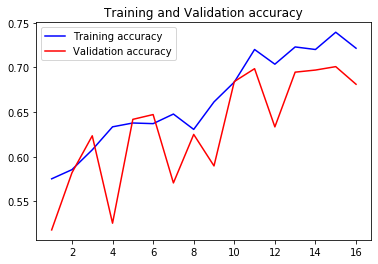

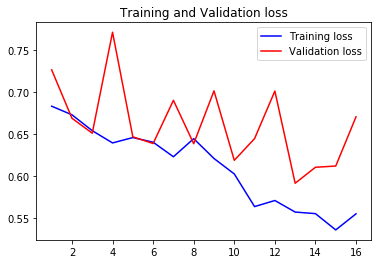

In [25]:
#  Plotting the train and val progress
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [26]:
#  Personal Code for testing for false evaluations over test data; feat and lab defined when selecting model input data
def document_mistakes(features, labels):
    print("Predicting...", end="\r")
    results = model.predict(np.array(features))
    print("Done Predicting", end="\r")
    predictions = []
    for val in results:
        predictions.append(int(round(val[0])))

    fps, names, labelz = [], [], {1:"Healthy", 0:"Sick"}
    for i in range(len(labels)-1):
        if predictions[i] != labels[i]:
            fps.append(i)
            names.append(labelz[predictions[i]])

    #  code for displaying false predictions
    print("False Predictions in %d%% of the data, exporting %d fakes..." % (100*len(fps)//len(labels), len(fps)))
    
    #  cleanout files with each new run
    if os.path.exists("./fakes") == True:
        shutil.rmtree("./fakes")
    os.mkdir("fakes")
    
    #  export false evaluations to fakes folder
    time = lambda a: datetime.datetime.now().strftime(a)
    for i, val in enumerate(fps):
        plt.imsave("./fakes/image{}-flagged:{}@{}.png".format(val, names[i], time("%X")), features[val])
    
document_mistakes(feat, lab)

False Predictions in 33% of the data, exporting 601 fakes...


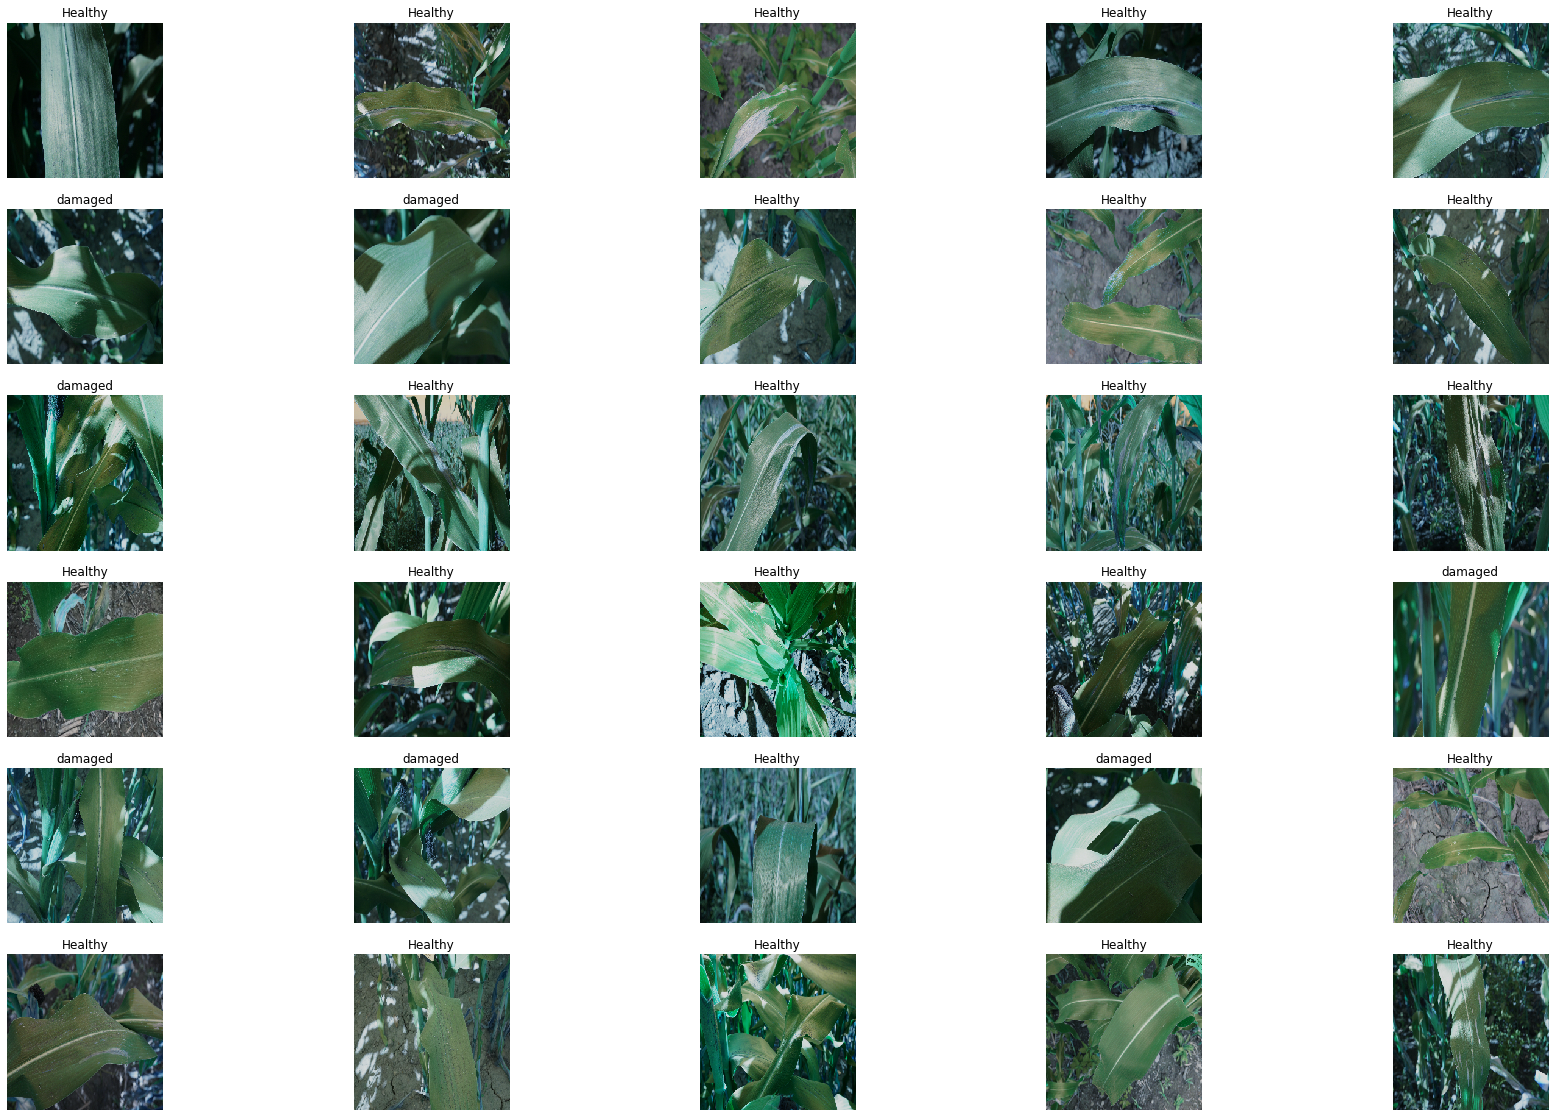

In [27]:
#  Test and display model prediction over generated images based on the training set

#  Configure augmentation settings for the generated evaluation images
test_datagen = ImageDataGenerator(rescale=1./300,
                                  rotation_range=0,
                                  width_shift_range=0.0,
                                  height_shift_range=0.0,
                                  shear_range=0.0,
                                  zoom_range=0.0,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  fill_mode="constant",
                                  cval=12)

def show_predictions(columns, total_images):  #  Displays the specified amount of augmented data and predictions in given number of rows
    all_images = x_training#training image reference      
    all_images = all_images[:total_images]
    text_labels, i = [], 0
    plt.figure(figsize=(30,20))
    for batch in test_datagen.flow(np.array(all_images), batch_size=1):
        pred = model.predict(batch)
        if pred > 0.5:
            text_labels.append('Healthy')
        else:
            text_labels.append('damaged')
        plt.subplot(((total_images-1)//columns)+1, columns, i+1)
        plt.title(text_labels[i])
        plt.axis("off")
        imgplot = plt.imshow(batch[0])
        i += 1
        if i % total_images == 0:
            break
            
show_predictions(5, 30)

# Conclusion

This first ever working run with Keras is promising and is reminiscent of what other first run projects have produced.
Some of the spikes in loss of accuracy could be attributed to bad data. Further investigation and tuning needed.

In [ ]:
gc.collect()